### 03. Calculate reflectance using DLS data
#### Gayantha R. L. Kodikara, 2023/08/24, @ UWM Update 2024/03/08, 31/05/2024

In [1]:
# Import libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import exiftool
import pysolar.solar as pysolar
from datetime import datetime, timedelta
import pytz

In [2]:
# Read raw image DN values
# reads 16 bit tif - this will likely not work for 12 bit images
imageR1  = 'IMG_0177_1.tif'
imageR2  = 'IMG_0177_2.tif'
imageR3  = 'IMG_0177_3.tif'
imageR4  = 'IMG_0177_4.tif'
imageR5  = 'IMG_0177_5.tif'
image1  = plt.imread(imageR1)

In [3]:
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    pose = et.get_tags([imageR1], tags=['XMP:Yaw','XMP:Pitch','XMP:Roll','EXIF:DateTimeOriginal','EXIF:SubSecTime'])

Yaw = float(pose[0].get('XMP:Yaw'))
Pitch = float(pose[0].get('XMP:Pitch'))
Roll = float(pose[0].get('XMP:Roll'))

In [4]:
print('Yaw:',Yaw,'Pitch:',Pitch,'Roll:',Roll)

Yaw: -0.1126574000634523 Pitch: 0.050523468944472925 Roll: 0.07207045614120443


In [5]:
# to get the sensor orientation in North-East-Down coordinates using Yaw, Pitch, and Roll of the camera.
c1 = np.cos(-Yaw)
s1 = np.sin(-Yaw)
c2 = np.cos(-Pitch)
s2 = np.sin(-Pitch)
c3 = np.cos(-Roll)
s3 = np.sin(-Roll)
Ryaw = np.array([[c1, s1, 0], [-s1, c1, 0], [0, 0, 1]])
Rpitch = np.array([[c2, 0, -s2], [0, 1, 0], [s2, 0, c2]])
Rroll = np.array([[1, 0, 0], [0, c3, s3], [0, -s3, c3]])
R = np.dot(Ryaw, np.dot(Rpitch, Rroll))
#n = np.dot(R, ori)
R

array([[ 0.99239291,  0.11574091,  0.04195647],
       [-0.1122758 ,  0.99067255, -0.07721427],
       [-0.05050198,  0.0719162 ,  0.99613132]])

In [6]:
# Get the utc time zone and date and time of the image capture.
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    time = et.get_tags([imageR1], tags=['EXIF:DateTimeOriginal','EXIF:SubSecTime'])

DateTime = time[0].get('EXIF:DateTimeOriginal')
SubTime = time[0].get('EXIF:SubSecTime')
utc_time = datetime.strptime(DateTime, "%Y:%m:%d %H:%M:%S")
# Find time zone
negative = 1.0
if SubTime < 0:
    negative = -1.0
    SubTime *= -1.0
SubTime = float('0.{}'.format(int(SubTime)))
SubTime *= negative
ms = SubTime * 1e3
utc_time += timedelta(milliseconds = ms)
timezone = pytz.timezone('UTC')
UTC_Time = timezone.localize(utc_time)

In [7]:
print('UTC_Time')
UTC_Time

UTC_Time


datetime.datetime(2023, 7, 12, 9, 57, 3, 959758, tzinfo=<UTC>)

In [8]:
# Get the position of the image sensor
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    posi = et.get_tags([imageR1], tags=['EXIF:GPSLatitude','EXIF:GPSLatitudeRef', 'EXIF:GPSLongitude', 'EXIF:GPSLongitudeRef', 'EXIF:GPSAltitude'])

Lat = posi[0].get('EXIF:GPSLatitude')
LatRef = posi[0].get('EXIF:GPSLatitudeRef')
Lon = posi[0].get('EXIF:GPSLongitude')
LonRef = posi[0].get('EXIF:GPSLongitudeRef')
Alt = posi[0].get('EXIF:GPSAltitude')
if LatRef == 'S':
    Lat *= -1.0
if LonRef == 'W':
    Lon *= -1.0
print('Lat:',Lat, 'Lon:', Lon, 'Alt:', Alt)

Lat: -2.3094972 Lon: 35.927391 Alt: 719.87


In [9]:
# Define DLS sensor orientation vector relative to dls pose frame
orientation = np.array([0,0,-1])
orientation

array([ 0,  0, -1])

In [10]:
# Calculate the sun altitude (elevation of the sun above the horizon), and sun azimuth (heading of the sun)
altitude = 0
azimuth = 0
altitude = pysolar.get_altitude(Lat,Lon,UTC_Time)
azimuth = pysolar.get_azimuth(Lat, Lon,UTC_Time)
sunAltitude = np.radians(np.array(altitude))
sunAzimuth = np.radians(np.array(azimuth))
# wrap range 0 to 2pi
sunAzimuth = sunAzimuth % (2 * np.pi)
print('altitude:',altitude,'azimuth:',azimuth)
print('SunAltitude:',sunAltitude, 'SunAzimuth:',sunAzimuth)

altitude: 65.44218565327262 azimuth: 351.5094193360959
SunAltitude: 1.1421816093510033 SunAzimuth: 6.134996719188294


In [11]:
# get the position of the sun in North-East-Down (NED) coordinate system
elements = (np.cos(sunAzimuth) * np.cos(sunAltitude),
            np.sin(sunAzimuth) * np.cos(sunAltitude),
            -np.sin(sunAltitude),)
nSun = np.array(elements).transpose()
nSun

array([ 0.41105619, -0.06136367, -0.90954236])

In [12]:
# to get the DLS orientation in North-East-Down coordinates using Yaw, Pitch, and Roll of the camera.
c1 = np.cos(-Yaw)
s1 = np.sin(-Yaw)
c2 = np.cos(-Pitch)
s2 = np.sin(-Pitch)
c3 = np.cos(-Roll)
s3 = np.sin(-Roll)
Ryaw = np.array([[c1, s1, 0], [-s1, c1, 0], [0, 0, 1]])
Rpitch = np.array([[c2, 0, -s2], [0, 1, 0], [s2, 0, c2]])
Rroll = np.array([[1, 0, 0], [0, c3, s3], [0, -s3, c3]])
R = np.dot(Ryaw, np.dot(Rpitch, Rroll))
n = np.dot(R, orientation)
nSensor = np.array(n)
nSensor

array([-0.04195647,  0.07721427, -0.99613132])

In [13]:
# Calculate the angle between DLS vector and Sun vector (sun-sensor angle)
angle = np.arccos(np.dot(nSun, nSensor))
angle

0.4863622950344405

In [14]:
# fresnel correction: multilayer transmission
polarization = [0.5, 0.5]
n = [1.000277,1.6,1.38]
angle_eff = np.copy(angle)
for i in range(0,len(n)-1):
    n1 = n[i]
    n2 = n[i+1]
    angle_eff = np.arcsin(np.sin(angle_eff)/n1)
angle_eff

0.29637198915678953

In [15]:
# Since the diffuser reflects more light at shallow angles than at steep angles,
# we compute a correction for this
## freshnel correction: fresnel transmission, compute fresnel transmission between 
## meadia with n1 and n2 refractive indices
## refractive index n1 to n2
    # teflon e.g. n2=1.38
    # polycarbonate n2=1.6 
    # polarization=[.5,.5] - unpolarized light
    # polarization=[1.,0] - s-polarized light - perpendicular to plane of incidence
    # polarization=[0,1.] - p-polarized light - parallel to plane of incidence
n1 = 1.000277
n2 = 1.38
polarization = [0.5,0.5]
f1 = np.cos(angle_eff)
f2 = np.sqrt(1-(n1/n2*np.sin(angle_eff))**2)
Rs = ((n1*f1 - n2*f2)/(n1*f1 + n2*f2))**2
Rp = ((n1*f2 - n2*f1)/(n1*f2 + n2*f1))**2
T = 1.0 - polarization[0]*Rs - polarization[1]*Rp
if T > 1:
    T = 0.0
if T < 0:
    T = 0.0
if np.isnan(T):
    T = 0.0
fresnel_correction =T
np.save('Fresnel_correction.npy', fresnel_correction)
fresnel_correction

0.9744450292563683

In [16]:
# Get the position of the image sensor

##### Band 1 #####
from exiftool import ExifToolHelper
with ExifToolHelper() as et:
    info1 = et.get_tags([imageR1], tags=['XMP:CentralWavelength','XMP:SpectralIrradiance'])
    info2 = et.get_tags([imageR2], tags=['XMP:CentralWavelength','XMP:SpectralIrradiance'])
    info3 = et.get_tags([imageR3], tags=['XMP:CentralWavelength','XMP:SpectralIrradiance'])
    info4 = et.get_tags([imageR4], tags=['XMP:CentralWavelength','XMP:SpectralIrradiance'])
    info5 = et.get_tags([imageR5], tags=['XMP:CentralWavelength','XMP:SpectralIrradiance'])

CenWL1 = info1[0].get('XMP:CentralWavelength')
SpeIrr1 = info1[0].get('XMP:SpectralIrradiance')

CenWL2 = info2[0].get('XMP:CentralWavelength')
SpeIrr2 = info2[0].get('XMP:SpectralIrradiance')

CenWL3 = info3[0].get('XMP:CentralWavelength')
SpeIrr3 = info3[0].get('XMP:SpectralIrradiance')

CenWL4 = info4[0].get('XMP:CentralWavelength')
SpeIrr4 = info4[0].get('XMP:SpectralIrradiance')

CenWL5 = info5[0].get('XMP:CentralWavelength')
SpeIrr5 = info5[0].get('XMP:SpectralIrradiance')

print('B1 Central Wavelength:',CenWL1, ', B1 Spectral Irradiance:', SpeIrr1)
print('B2 Central Wavelength:',CenWL2, ', B2 Spectral Irradiance:', SpeIrr2)
print('B3 Central Wavelength:',CenWL3, ', B3 Spectral Irradiance:', SpeIrr3)
print('B4 Central Wavelength:',CenWL4, ', B4 Spectral Irradiance:', SpeIrr4)
print('B5 Central Wavelength:',CenWL5, ', B5 Spectral Irradiance:', SpeIrr5)

B1 Central Wavelength: 475 , B1 Spectral Irradiance: 1.2306348085403442
B2 Central Wavelength: 560 , B2 Spectral Irradiance: 1.1394789218902588
B3 Central Wavelength: 668 , B3 Spectral Irradiance: 1.0169126987457275
B4 Central Wavelength: 840 , B4 Spectral Irradiance: 0.52389013767242432
B5 Central Wavelength: 717 , B5 Spectral Irradiance: 0.83006113767623901


In [17]:
# Now we can correct the raw DLS readings and compute the irradiance on level ground
# For Band 1
dls_irradiances = []
center_wavelengths = []
dir_dif_ratio = 6.0
percent_diffuse = 1.0/dir_dif_ratio

#### Band 1 ####
# measured Irradiance / fresnelCorrection
sensor_irradiance1 = float(SpeIrr1) / fresnel_correction
untilted_direct_irr1 = sensor_irradiance1 / (percent_diffuse + np.cos(angle_eff))

# compute irradiance on the ground using the solar altitude angle
dls_irr1 = untilted_direct_irr1 * (percent_diffuse + np.sin(sunAltitude))
dls_irradiances.append(dls_irr1)
center_wavelengths.append(CenWL1)

#### Band 2 ####
# measured Irradiance / fresnelCorrection
sensor_irradiance2 = float(SpeIrr2) / fresnel_correction
untilted_direct_irr2 = sensor_irradiance2 / (percent_diffuse + np.cos(angle_eff))

# compute irradiance on the ground using the solar altitude angle
dls_irr2 = untilted_direct_irr2 * (percent_diffuse + np.sin(sunAltitude))
dls_irradiances.append(dls_irr2)
center_wavelengths.append(CenWL2)

#### Band 3 ####
# measured Irradiance / fresnelCorrection
sensor_irradiance3 = float(SpeIrr3) / fresnel_correction
untilted_direct_irr3 = sensor_irradiance3 / (percent_diffuse + np.cos(angle_eff))

# compute irradiance on the ground using the solar altitude angle
dls_irr3 = untilted_direct_irr3 * (percent_diffuse + np.sin(sunAltitude))
dls_irradiances.append(dls_irr3)
center_wavelengths.append(CenWL3)

#### Band 4 ####
# measured Irradiance / fresnelCorrection
sensor_irradiance4 = float(SpeIrr4) / fresnel_correction
untilted_direct_irr4 = sensor_irradiance4 / (percent_diffuse + np.cos(angle_eff))

# compute irradiance on the ground using the solar altitude angle
dls_irr4 = untilted_direct_irr4 * (percent_diffuse + np.sin(sunAltitude))
dls_irradiances.append(dls_irr4)
center_wavelengths.append(CenWL4)

#### Band 5 ####
# measured Irradiance / fresnelCorrection
sensor_irradiance5 = float(SpeIrr5) / fresnel_correction
untilted_direct_irr5 = sensor_irradiance5 / (percent_diffuse + np.cos(angle_eff))

# compute irradiance on the ground using the solar altitude angle
dls_irr5 = untilted_direct_irr5 * (percent_diffuse + np.sin(sunAltitude))
dls_irradiances.append(dls_irr5)
center_wavelengths.append(CenWL5)

In [18]:
dls_irradiances

[1.2102136169417286,
 1.1205703738587716,
 1.0000380183644832,
 0.5151966887273849,
 0.816287077806149]

In [19]:
center_wavelengths

[475, 560, 668, 840, 717]

In [20]:
file = np.vstack((center_wavelengths, dls_irradiances))
file

array([[4.75000000e+02, 5.60000000e+02, 6.68000000e+02, 8.40000000e+02,
        7.17000000e+02],
       [1.21021362e+00, 1.12057037e+00, 1.00003802e+00, 5.15196689e-01,
        8.16287078e-01]])

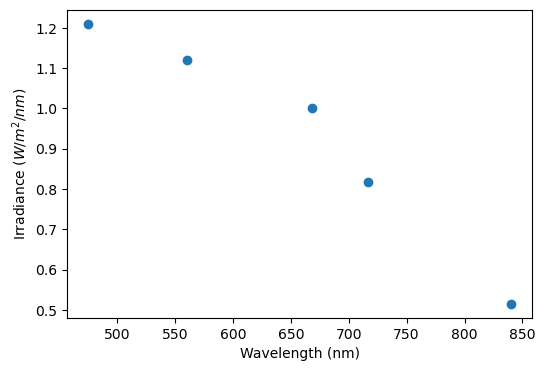

In [21]:
plt.figure(figsize=(6, 4))
plt.scatter(file[0],file[1])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance ($W/m^2/nm$)')
plt.savefig('DLS_Irradiance.png', dpi= 300)
plt.show()

In [22]:
# Save the Reference Panel Field Spectral data
np.save('DLS_Irradiances.npy', dls_irradiances)

move to next chapter ;-)